### 선형회귀기반 분류 알고리즘 학습 - LogisticRegression + 교차검증

- 이진분류 및 다중분류 가능
- 분류지만 선형회귀식기반의 알고리즘이라서 Regresion

[1] 모듈 로딩 및 데이터 준비 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
                                    #쪼개기
from sklearn.linear_model import LogisticRegression
                                    #로지스틱회귀
import matplotlib.pyplot as plt

#### [1] 데이터 준비 및 확인

In [2]:
filename='../data/iris.csv'

In [3]:
## 데이터 로딩
irisDF= pd.read_csv(filename)

In [4]:
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


- 3개모두.

In [5]:
irisDF.variety.unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [6]:
# boolean indedxing
dataDF=irisDF.copy()
dataDF.shape

(150, 5)

In [7]:
dataDF.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


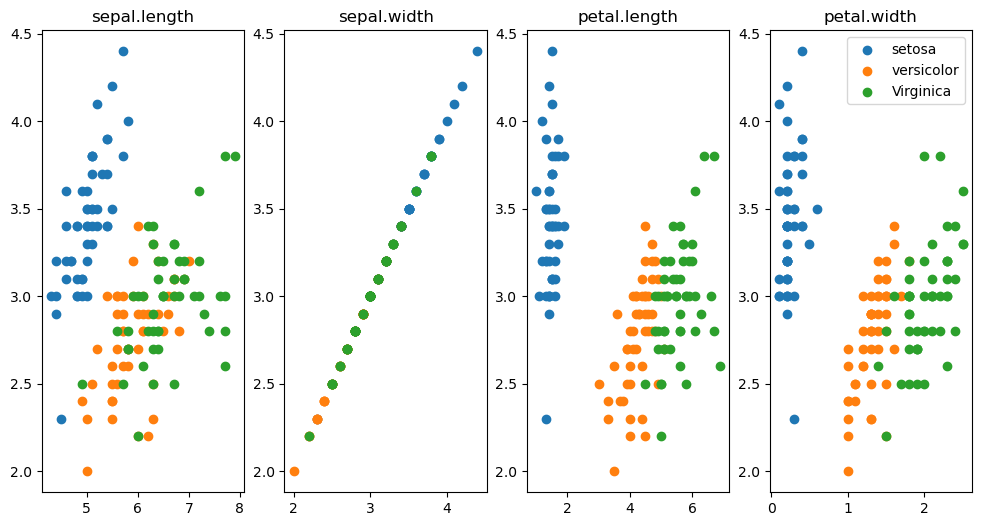

In [8]:
# 2개 품종 식별 가능한 피쳐 선택.
fig, axe = plt.subplots(1,4, figsize=(12,6))
axe = axe.flatten()
s_mask = dataDF[dataDF['variety']=='Setosa']
v_mask = dataDF[dataDF['variety']=='Versicolor']
c_mask = dataDF[dataDF['variety']=='Virginica']

for ax, i in zip(axe, dataDF.columns[0:4]):
    ax.scatter(s_mask[i], s_mask['sepal.width'], label='setosa')
    ax.scatter(v_mask[i], v_mask['sepal.width'], label='versicolor')
    ax.scatter(c_mask[i], c_mask['sepal.width'], label='Virginica')
    ax.set_title(i)


plt.legend()
plt.show()

- 꽃잎의 길이와 너비(petal.length, petal.width) 특성만 추출

In [9]:
dataDF.columns

Index(['sepal.length', 'sepal.width', 'petal.length', 'petal.width',
       'variety'],
      dtype='object')

In [10]:
dataDF=dataDF[dataDF.columns[2:]].copy()

In [11]:
dataDF.shape
#각 50개씩 있음.

(150, 3)

In [12]:
dataDF.head(3)

,petal.length,petal.width,variety
0,1.4,0.2,Setosa
1,1.4,0.2,Setosa
2,1.3,0.2,Setosa


In [13]:
## 품종컬럼 문자열  ==> 수치형태 변환한 컬럼 추가

labelToNum={'Setosa' : 0, 'Versicolor':1, 'Virginica':2}
dataDF['variety_no']=dataDF.variety.replace(labelToNum )

C:\Users\matdo\AppData\Local\Temp\ipykernel_15040\2192808530.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataDF['variety_no']=dataDF.variety.replace(labelToNum )


In [14]:
dataDF.head(3)

,petal.length,petal.width,variety,variety_no
0,1.4,0.2,Setosa,0
1,1.4,0.2,Setosa,0
2,1.3,0.2,Setosa,0


In [15]:
dataDF.corr(numeric_only=True)

,petal.length,petal.width,variety_no
petal.length,1.000000,0.962865,0.949035
petal.width,0.962865,1.000000,0.956547
variety_no,0.949035,0.956547,1.000000


In [16]:
dataDF = dataDF[dataDF.columns[0:]]
dataDF

,petal.length,petal.width,variety,variety_no
0,1.4,0.2,Setosa,0
1,1.4,0.2,Setosa,0
2,1.3,0.2,Setosa,0
3,1.5,0.2,Setosa,0
4,1.4,0.2,Setosa,0
...,...,...,...,...
145,5.2,2.3,Virginica,2
146,5.0,1.9,Virginica,2
147,5.2,2.0,Virginica,2
148,5.4,2.3,Virginica,2


#### [2] 데이터 가공

- 피쳐/특성/독립과 타겟/클래스/종속변수 분리

In [17]:
featureDF = dataDF[dataDF.columns[:2]]
classDF = dataDF.variety_no

In [18]:
dataDF

,petal.length,petal.width,variety,variety_no
0,1.4,0.2,Setosa,0
1,1.4,0.2,Setosa,0
2,1.3,0.2,Setosa,0
3,1.5,0.2,Setosa,0
4,1.4,0.2,Setosa,0
...,...,...,...,...
145,5.2,2.3,Virginica,2
146,5.0,1.9,Virginica,2
147,5.2,2.0,Virginica,2
148,5.4,2.3,Virginica,2


In [19]:
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')

featureDF : (150, 2)  classDF : (150,)


- 훈련용/테스트용 분리

In [20]:
## - 회귀가 아니고 분류 시행시에는
## 훈련용이랑 테스트용에 동일한 비율로 
## 타겟이 배분되어야 한다.
## setosa : versi:Virginica = 1:1:1
#  ==> stratify 매개변수: 타겟 데이터셋의 클래스/라벨 비율에 맞게 학습용/테스트용 분리.
# pytorch엔 없음.

train_X, test_X, train_y, test_y = train_test_split(featureDF, classDF,
                                                    random_state=7,
                                                    test_size=0.2,
                                                    stratify=classDF)
print(f"train_X => {train_X.ndim}D {train_X.shape} / test_X => {test_X.ndim}D, {test_X.shape}")
print(f"train_y => {train_y.ndim}D {train_y.shape}, / test_y => {test_y.ndim}D, {test_y.shape}")
    


train_X => 2D (120, 2) / test_X => 2D, (30, 2)
train_y => 1D (120,), / test_y => 1D, (30,)


In [21]:
## 데이터셋별로 클래스 갯수 확인
test_y.value_counts(), train_y.value_counts()

(variety_no
 2    10
 0    10
 1    10
 Name: count, dtype: int64,
 variety_no
 2    40
 0    40
 1    40
 Name: count, dtype: int64)

- 특성/피쳐 2개에 대한 스케일링 진행

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

In [23]:
## StandardScaler : 평균 0, 표준편차 1 즉, 정규분포 따르도록 스케일링.
## 훈련용 DS 기반 스케일러는 테스트용 DS, 사용자 데이터에 대해서 스케일링 진행함.
## 


scaler = StandardScaler()

scaler.fit(train_X)

StandardScaler()

In [24]:
## fit() 후에 설정되는 파라미터들 ==> 모델 파라미터 . abd_
## 후행.

print(scaler.var_, scaler.mean_, scaler.feature_names_in_)

[3.1731     0.59086042] [3.78   1.2075] ['petal.length' 'petal.width']


In [25]:
# 훈련데이터와 테스트 데이터 스케일링 진행
# ==> 훈련용 생성한 스케일러로 훈련용, 테스트용 변환 진행 
# ==> 향후 임의의 새로운 데이터 예측(predict)시에도 해당 스케일러 적용
train_scaled_X = scaler.transform(train_X)
test_scaled_X = scaler.transform(test_X)

#### [3] 학습 
- 메인학습 : 지도학습 - 분류
- 세부학습 : 선형모델 로지스틱회귀

In [26]:
# 학습모델 객체
logR=LogisticRegression()

In [27]:
# 학습 진행 ==> 훈련용 데이터 진행 fit(2D, 1D)
logR.fit(train_scaled_X, train_y)

LogisticRegression()

In [28]:
# 학습 진행 후 설정되는 매개변수/파라미터 ===> 모델 파라미터 
# 파라메타명_
logR.classes_

array([0, 1, 2])

In [29]:
## 피쳐 갯수만큼 존재.
logR.coef_

array([[-2.42949093, -2.10048266],
       [ 0.18857774, -0.43406497],
       [ 2.24091319,  2.53454763]])

In [30]:
# BIAS, 편향, 바이어스, 절편
logR.intercept_

array([-0.56571921,  1.82482602, -1.25910681])

#### [4] 성능평가
- 이유 : 모델이 제대로 잘 만들어 졌는지 확인
- 과대적합/과소적합 체크
    * 과대적합/과적합/오버피팅(Overfitting) : 훈련 점수 > 테스트 점수
    * 과소적합/언더피팅(Underfitting) : 훈련과 테스트 점수 모두 낮음
    * 최적적합 : 훈련 점수와 테스트 점수 비슷 높은 점수 

- 점수 : 정확도(accuary_score)

In [31]:
train_score=logR.score(train_scaled_X, train_y)
test_score= logR.score(test_scaled_X, test_y)

In [32]:
print(f'train_score : {train_score}, test_score  : {test_score}')

train_score : 0.95, test_score  : 1.0


- 분류용 성능지표 ==>  sklearn.metrics 모듈
    - 정밀도(precision) : 모델(예측값) 기준에서 양성/POsitivie를 제대로 예측한 비율
    - 재현율(Recall) : 정답기준에서 양성/Positive를 제대로 예측한 비율
    - F1-score : 정밀도와 재현율을 조합한 계산법 <== 일반적인 경우 대부분 분류성능지표로 사용
    - 정확도(Accuracy) : 정답을 맞춘 비율 <== 불균형 데이터셋에 신뢰성 떨어짐
    - 오차행렬(Confusion_matrix) : 2진 분류에서 정답과 예측에 대한 평가표
    

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
# 테스트 데이터기반으로 예측값 추출
y_pred=logR.predict(test_scaled_X)

y_pred

array([2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2, 0,
       1, 0, 2, 2, 2, 1, 0, 2])

- [정밀도 점수] 

In [35]:
precision_score(test_y, y_pred, labels=[0,1,2], average='micro')
recall_score(test_y, y_pred, labels=[0,1,2], average='micro')
f1_score(test_y, y_pred, labels=[0,1,2], average='micro')


1.0

In [36]:
confusion_matrix(test_y, y_pred, labels=[0,1,2])

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 10]])

In [37]:

print( classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



- 오차확인 : 손실/비용함수 => 알고리즘 마다 다름 log_loss()

In [38]:
from sklearn.metrics import log_loss


In [39]:
np.set_printoptions(precision=10, suppress=True)

In [40]:
# numpy에서의 DataFrame의 replace()와 동일 기능 변경 
# y = 1일 때 오차, y=0일 때 오차계산 ==> 손실/비용계산
test_y_ = np.where(test_y, 1, 0)
y_pred_ = np.where(y_pred, 1, 0)  

loss = log_loss(test_y_, y_pred_)
print(test_y_, y_pred_)
print(f'loss : {loss :.6f}')

[1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1] [1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1]
loss : 0.000000


### 교차검증 ---------------------------------------------------------

- 데이터부족에 따른 과대적합/과적합/오버피팅을 해결하기 위한 방안
- 기본 데이터 분리 갯수 => 5 (지금껏 해당 기능을 사용해 보니 가장 성능이 좋았음)
- 데이터 구성
    * 입력 : 훈련데이터 , 타겟데이터
    * 분리 : 훈련데이터 ==> n등분(기:5)
        - 학습 완료 후 현재 모델에 대한 검사 진행 ==> 검증데이터필요
        - 1/n : 검증데이터로 사용
        - n-1/n : 훈련데이터로 사용
        - [중요] 검증데이터는 매번 변경
            * 검 훈 훈 훈 훈
            * 훈 검 훈 훈 훈
            * 훈 훈 검 훈 훈
            * 훈 훈 훈 검 훈
            * 훈 훈 훈 훈 검

In [41]:
# 모듈 로딩 --------------------------------------------------
from sklearn.model_selection import cross_validate

In [42]:
# 모델객체, 훈련데이터, 타겟데이터
result= cross_validate(logR, train_scaled_X, train_y)

In [43]:
# 결과 result => dict 형태
for key, value in result.items(): print(key, value)

fit_time [0.0080015659 0.0090019703 0.010001421  0.0080020428 0.011973381 ]
score_time [0.0010004044 0.004001379  0.0020003319 0.0015201569 0.0030009747]
test_score [1.           0.9583333333 1.           0.9166666667 0.875       ]


In [44]:
# 모델객체, 훈련데이터, 타겟데이터 , 훈련결과, 최고의 모델 
result2= cross_validate(logR, train_scaled_X, train_y, 
                        return_estimator=True, 
                        return_train_score=True)

In [45]:
for key, value in result2.items(): print(key, value)

fit_time [0.0070021152 0.0040011406 0.0050008297 0.0040009022 0.0080020428]
score_time [0.0009996891 0.0010006428 0.0020010471 0.0009999275 0.0020003319]
estimator [LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()]
test_score [1.           0.9583333333 1.           0.9166666667 0.875       ]
train_score [0.9270833333 0.9479166667 0.9375       0.9479166667 0.96875     ]


In [46]:
# test_score와 train_score 값 비교해서 과대적합/과적합/오버피팅이 되지 않은
# 가장 좋음 모델 선택 후 추출
best_estimator=result2['estimator'][2]

In [81]:
featureDF[:1]

,petal.length,petal.width
0,1.4,0.2


In [82]:
new_data = pd.DataFrame([[1.4, 0.8]], columns=featureDF.columns)
new_data_ = scaler.transform(new_data)

In [83]:
best_estimator.predict(new_data_)

array([0])

In [84]:
best_estimator.predict_proba(new_data_)

array([[0.863915357 , 0.1359522934, 0.0001323496]])